<h1 style="color:rgb(0,120,170)">344.038, KV Multimedia Search and Retrieval (WS2023/24)</h1>
<h2 style="color:rgb(0,120,170)">Task 2_Group B</h2>

| First Name | Family Name  | Matr.Nr   |
|:-----------|:-------------|:----------|
| Branko     | Paunović     | K12046370 |
| Lukas      | Troyer       | K12006666 |
| Hadi       | Sanaei       | K11733444 |

# Retrieval systems

#### Import datasets, setup helper interfaces

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
np.random.seed(42)
from sklearn.decomposition import PCA

from song import songs
from datasets import datasets, LocalDataset
from retrieval import Retrieval

#### Prompt for user input

In [3]:
# Number of similar songs to retrieve
num_top_similar = int(input("Enter the number of top similar tracks: "))

# Example:
#   - Title: Letterman
#   - Artist: Wiz Khalifa
query, query_row_id = songs.prompt_song_query()

## Video-Based(\<similarity\>, \<feature\>)
### 1. Video-based(similarity, incp)

In [12]:
retN = Retrieval(n=1, use_cache=True)
Retrieval.create_df_from_tracks(retN.top_similar_tracks(query_row_id, dataset=datasets.resnet))

using cached


,id,similarity,song,artist,album_name
0,GY25og83Ng5O9s75,0.783461,Remind Me,Röyksopp,Melody A.M.


In [19]:
Retrieval.create_df_from_tracks(retN.top_similar_tracks(query_row_id, dataset=datasets.vgg))

,id,similarity,song,artist,album_name
0,GY25og83Ng5O9s75,0.758116,Remind Me,Röyksopp,Melody A.M.
1,6DiqMk5OTw4xE8tG,0.748836,Alison,Elvis Costello,My Aim Is True
2,UUT3MnnHgEmcJVPR,0.743280,After the Rain,John Coltrane,Impressions
3,f2tGa2kADrdE7XJX,0.739452,Oh What A Night,The Dells,At Their Very Best
4,YCrt9iFhB5Y8XXMT,0.739356,Mesmo que Mude,Bidê ou Balde,É Preciso Dar Vazão aos Sentimentos!
...,...,...,...,...,...
995,jOEL85ImTTwtWGYP,0.638873,Open Your Heart,Europe,Wings Of Tomorrow
996,OvWUN6tNDYIxgrn8,0.638819,Drain The Blood,The Distillers,Coral Fang (Alternate Cover PA Version)
997,5k0J8Khb6W0O7vt8,0.638795,Edge Of A Revolution,Nickelback,No Fixed Address
998,Z4W9fn9FHHNMtdPh,0.638787,Stratford-on-Guy,Liz Phair,Exile In Guyville (Remastered)


In [20]:
Retrieval.create_df_from_tracks(retN.top_similar_tracks(query_row_id, dataset=datasets.incp))

,id,similarity,song,artist,album_name
0,2wPQxBfn7e7MjdWu,0.902862,Blue Eyed Hexe,Pixies,Indie Cindy
1,Dtf7ZV2mJSpyuvdD,0.901582,Hollow Man,R.E.M.,Accelerate
2,IKEsVgEXFbIw7xc0,0.900696,House Of Love,East 17,Walthamstow
3,GY25og83Ng5O9s75,0.900293,Remind Me,Röyksopp,Melody A.M.
4,lQQp4nJxCBg0KYhP,0.898965,Looking For Clues,Robert Palmer,Clues
...,...,...,...,...,...
995,knCRp64TFxWO7HWZ,0.867551,Yoncé,Beyoncé,The Lion King: The Gift
996,qGHDYOyP7HMPvxKJ,0.867532,Shout,Tears for Fears,Songs From The Big Chair
997,P8ocVhSIrHZczAww,0.867516,Rapture,Blondie,Greatest Hits: Blondie
998,4sZGmR6zthqYotiU,0.867504,Alive,Da Buzz,The Best Of Da Buzz 1999-2007


## Fusion-Based (\<similarity\>, \<feature\>)
### Early Fusion

In [ ]:
def early_fusion_dataframe(d1: LocalDataset, d2: LocalDataset):
    if len(d1.df) != len(d2.df):
        raise ValueError("Both dataframes must have the same number of rows")

    # Concatenate dataframes along columns (axis=1)
    df1_pca = pd.DataFrame(PCA(n_components=0.8).fit_transform(d1.df.iloc[:, 1:]))
    df1_pca["id"] = d1.df["id"]

    df2_pca = pd.DataFrame(PCA(n_components=0.8).fit_transform(d2.df.iloc[:, 1:]))
    df2_pca["id"] = d2.df["id"]
    
    fused_df = pd.concat([df1_pca, df2_pca], axis=1)  
    return fused_df


df_ef = early_fusion_dataframe(datasets.musicnn, datasets.resnet)
dataset_early_fusion = LocalDataset("early_fusion-musicnn_resnet", df_ef)

In [ ]:
df_ef.head()

In [ ]:
retN = Retrieval(n=num_top_similar)
Retrieval.create_df_from_tracks(retN.top_similar_tracks(query_row_id, dataset=dataset_early_fusion))

### Late Fusion

In [ ]:
#
# Late fusion - Score Aggregation Fusion for two DataFrames (text and audio)
#
def late_fusion_df(d1: LocalDataset, d2: LocalDataset, d1_weight: float, d2_weight: float):
    # Rename the 'similarity' column
    df_1 = d1.df.copy().rename(columns={'similarity': 'similarity_d1'})
    df_2 = d2.df.copy().rename(columns={'similarity': 'similarity_d2'})

    # Merge DataFrames on 'id'
    merged_df = pd.merge(df_2[['id', 'similarity_d2']], df_1, on='id')

    # Assuming the scores are already normalized between 0 and 1
    normalized_d1_scores = merged_df['similarity_d1'].values
    normalized_d2_scores = merged_df['similarity_d2'].values

    # Aggregate scores
    aggregated_scores = d1_weight * normalized_d1_scores + d2_weight * normalized_d2_scores

    # Add the aggregated scores to the DataFrame
    merged_df['aggregated_score'] = aggregated_scores

    # Sort DataFrame based on aggregated scores
    sorted_fusion_df = merged_df.sort_values(by='aggregated_score', ascending=False)
    return sorted_fusion_df

fusion_results_df = late_fusion_df(
    datasets.tf_idf,
    datasets.musicnn,
    d1_weight=0.6,
    d2_weight=0.4
)
fusion_results_df

In [ ]:
#
# Late fusion - Rank-Level Fusion for two DataFrames (video and audio)
#
def rank_level_fusion_video_audio(d1: LocalDataset, d2: LocalDataset, d1_weight: float, d2_weight: float):
    # Rename the 'similarity' column
    video_scores = d1.df.copy().rename(columns={'similarity': 'similarity_video'})
    audio_scores = d2.df.copy().rename(columns={'similarity': 'similarity_audio'})

    # Merge DataFrames on 'id'
    merged_df = pd.merge(audio_scores[['id', 'similarity_audio']], video_scores, on='id')

     # Assuming the scores are already normalized between 0 and 1
    normalized_video_scores = merged_df['similarity_video'].values
    normalized_audio_scores = merged_df['similarity_audio'].values

    # Convert similarity scores to ranks using pandas Series
    video_ranks = pd.Series(normalized_video_scores).rank(ascending=False)
    audio_ranks = pd.Series(normalized_audio_scores).rank(ascending=False)

    # Rank-level fusion: Combine the ranks using weighted sum
    aggregated_ranks = d1_weight * video_ranks + d2_weight * audio_ranks

    # Add the aggregated ranks to the DataFrame
    merged_df['aggregated_rank'] = aggregated_ranks

    # Sort DataFrame based on aggregated ranks
    sorted_fusion_df = merged_df.sort_values(by='aggregated_rank')
    return sorted_fusion_df

# Example usage
fusion_results_df = rank_level_fusion_video_audio(
    datasets.resnet,
    datasets.musicnn,
    d1_weight=0.6,
    d2_weight=0.4
)


In [ ]:
# Display the fused results
print("Rank-Level Fusion Results:")
print(fusion_results_df[['id', 'similarity_video', 'similarity_audio', 'aggregated_rank']])

# Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

# Obtain necessary information and store for easy interop
from genres import Genres
from utils import get_retrieval_names_for_types

genres = Genres()

# TODO: check if we havent forgotten any constraints
our_chosen_retrievals = [
    # those have to be chosen because of the task description
    "random_baseline",
    "early_fusion",
    "late_fusion",
    "text_tf_idf",
    "text_bert",
    "text_word2vec",
    "musicnn",

    # the ones below have been chosen because they are the best performing ones
    # while still staying within the limits of the task description

    # one of the mfccs
    "mfcc_bow",

    # one of the video features
    "video_resnet",

    # one of the BLFs
    "blf_spectral",

    # one of the i-vectors
    "ivec256"
]


  --> Loading pickled data from pickled_state/precomputed_genres.pickle


## Accuracy
#### 1. Precision@k & Recall@k

In [7]:
from precision_recall import PrecisionRecall

pr = PrecisionRecall(genres)
pr.compute()

Error syncing cache with disk: Unterminated string starting at: line 1 column 32551791 (char 32551790)
Calculating precision and recall for random_baseline
  --> Loading pickled data from pickled_state/precision_recall_random_baseline.pickle
Calculating precision and recall for text_tf_idf
  --> Loading pickled data from pickled_state/precision_recall_text_tf_idf.pickle
Calculating precision and recall for text_bert
  --> Loading pickled data from pickled_state/precision_recall_text_bert.pickle
Calculating precision and recall for text_word2vec
  --> Loading pickled data from pickled_state/precision_recall_text_word2vec.pickle
Calculating precision and recall for musicnn
  --> Loading pickled data from pickled_state/precision_recall_musicnn.pickle
Calculating precision and recall for mfcc_bow
  --> Loading pickled data from pickled_state/precision_recall_mfcc_bow.pickle
Calculating precision and recall for mfcc_stats
  --> Loading pickled data from pickled_state/precision_recall_mfcc_s

In [ ]:
# pr.plot_each(our_chosen_retrievals) # i dont think it makes sense to plot
# each one in a separate plot; it just takes up space and is hard to compare

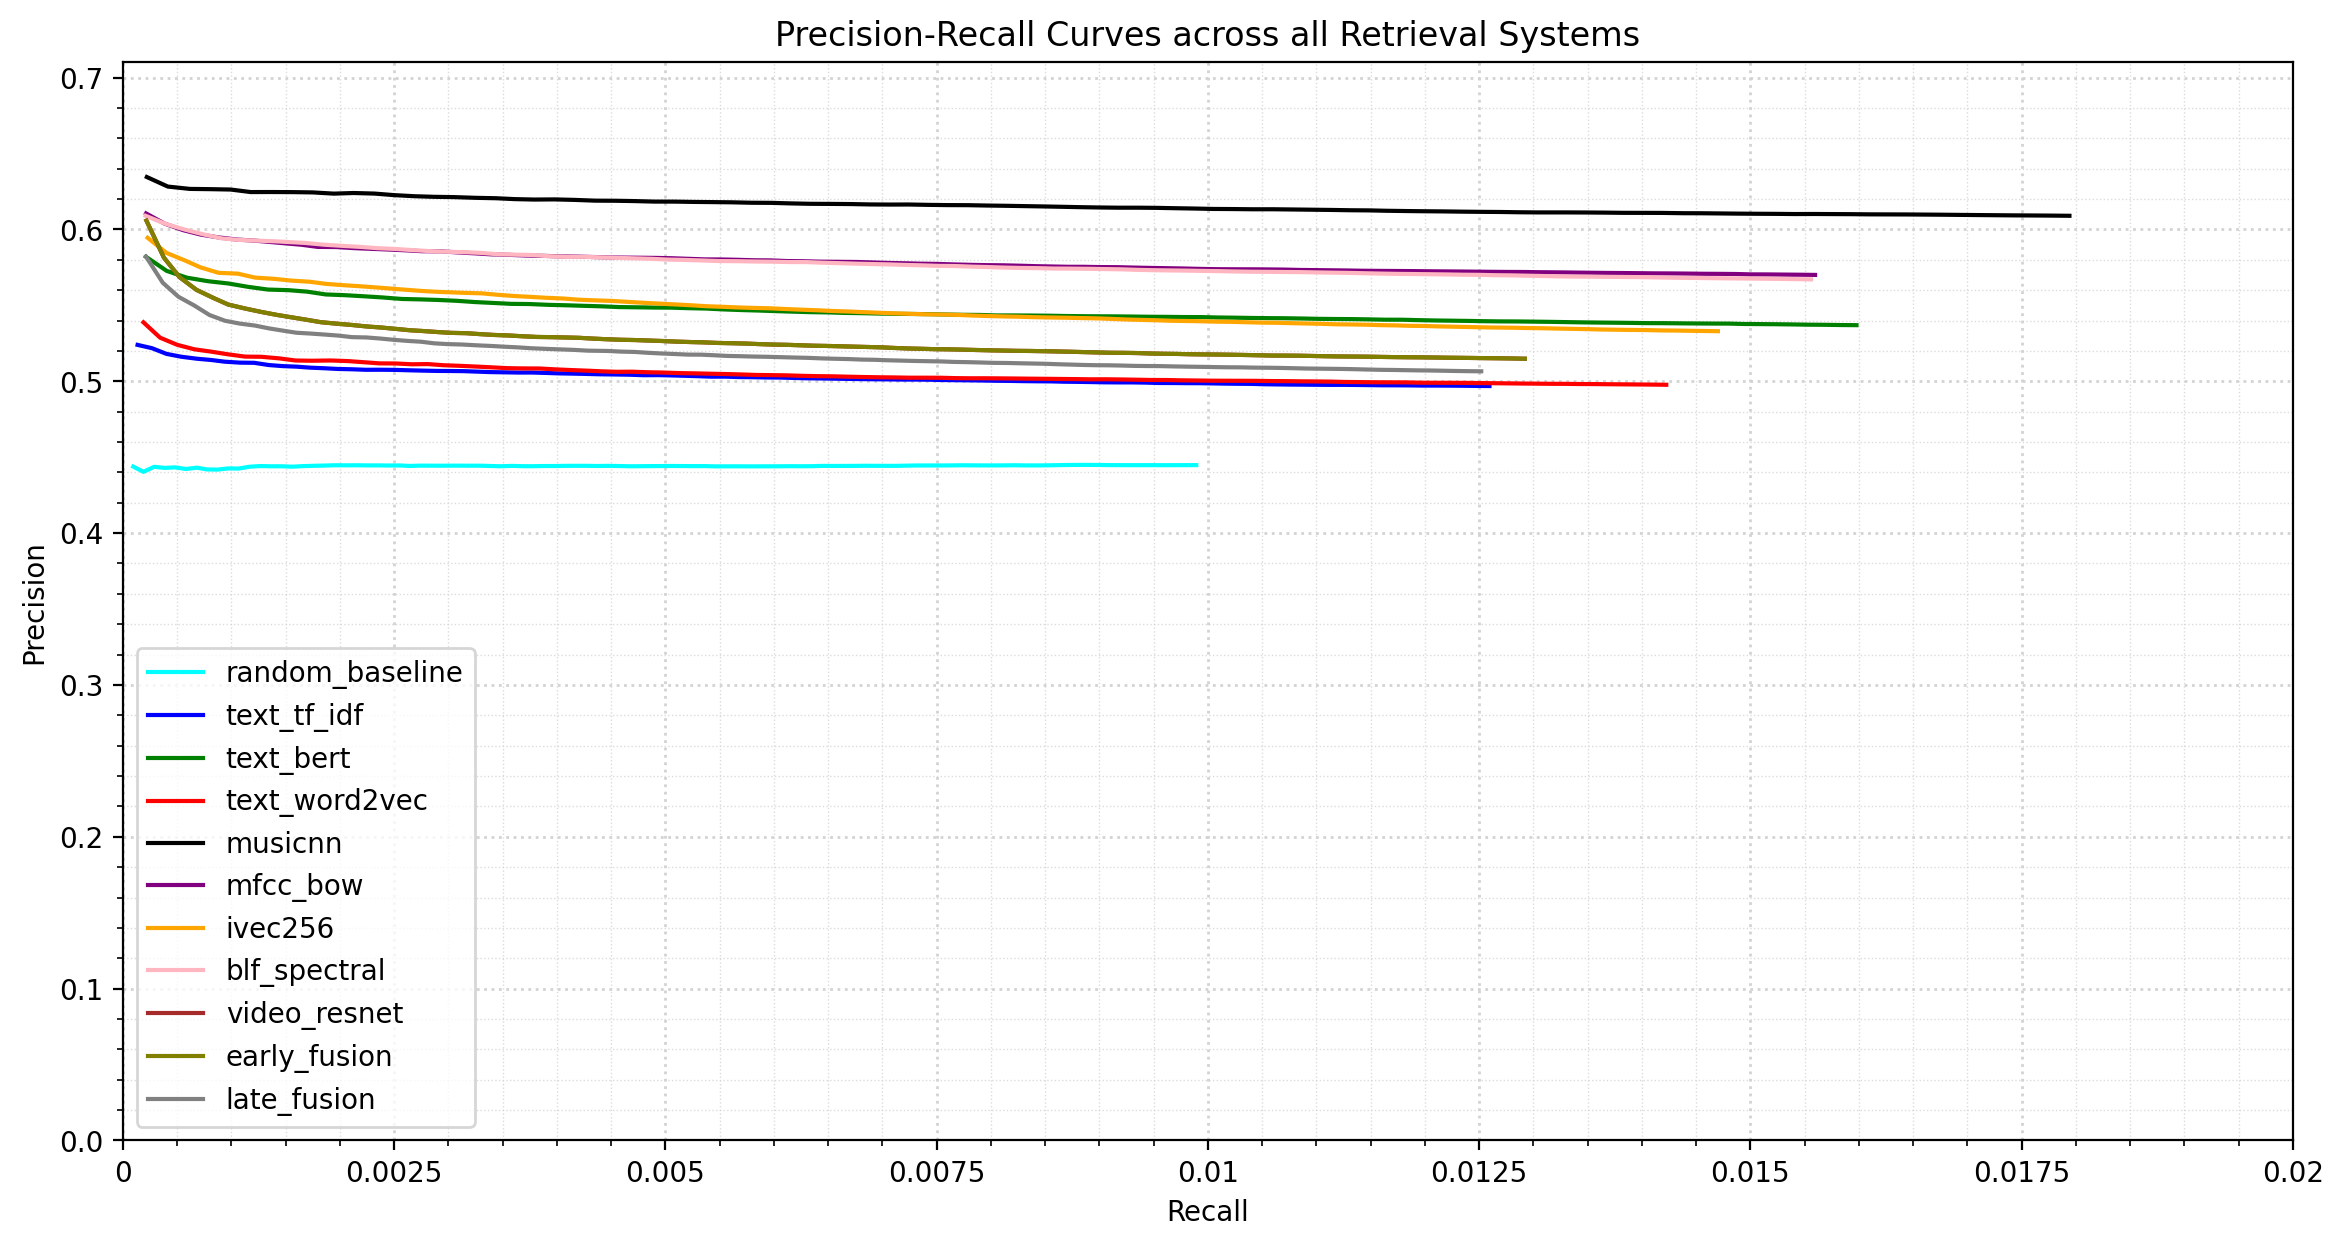

In [8]:
pr.plot_all_single(our_chosen_retrievals)

#### 2. nDCG@10

Error syncing cache with disk: Unterminated string starting at: line 1 column 32551791 (char 32551790)
Prepared 11 chunks to compute nDCG


Computing nDCG in chunks of 1000:   0%|          | 0/11 [00:00<?, ?it/s]

  --> Loading pickled data from pickled_state/ndcg_10_chunk_0.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_1.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_2.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_3.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_4.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_5.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_6.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_7.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_8.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_9.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_10.pickle


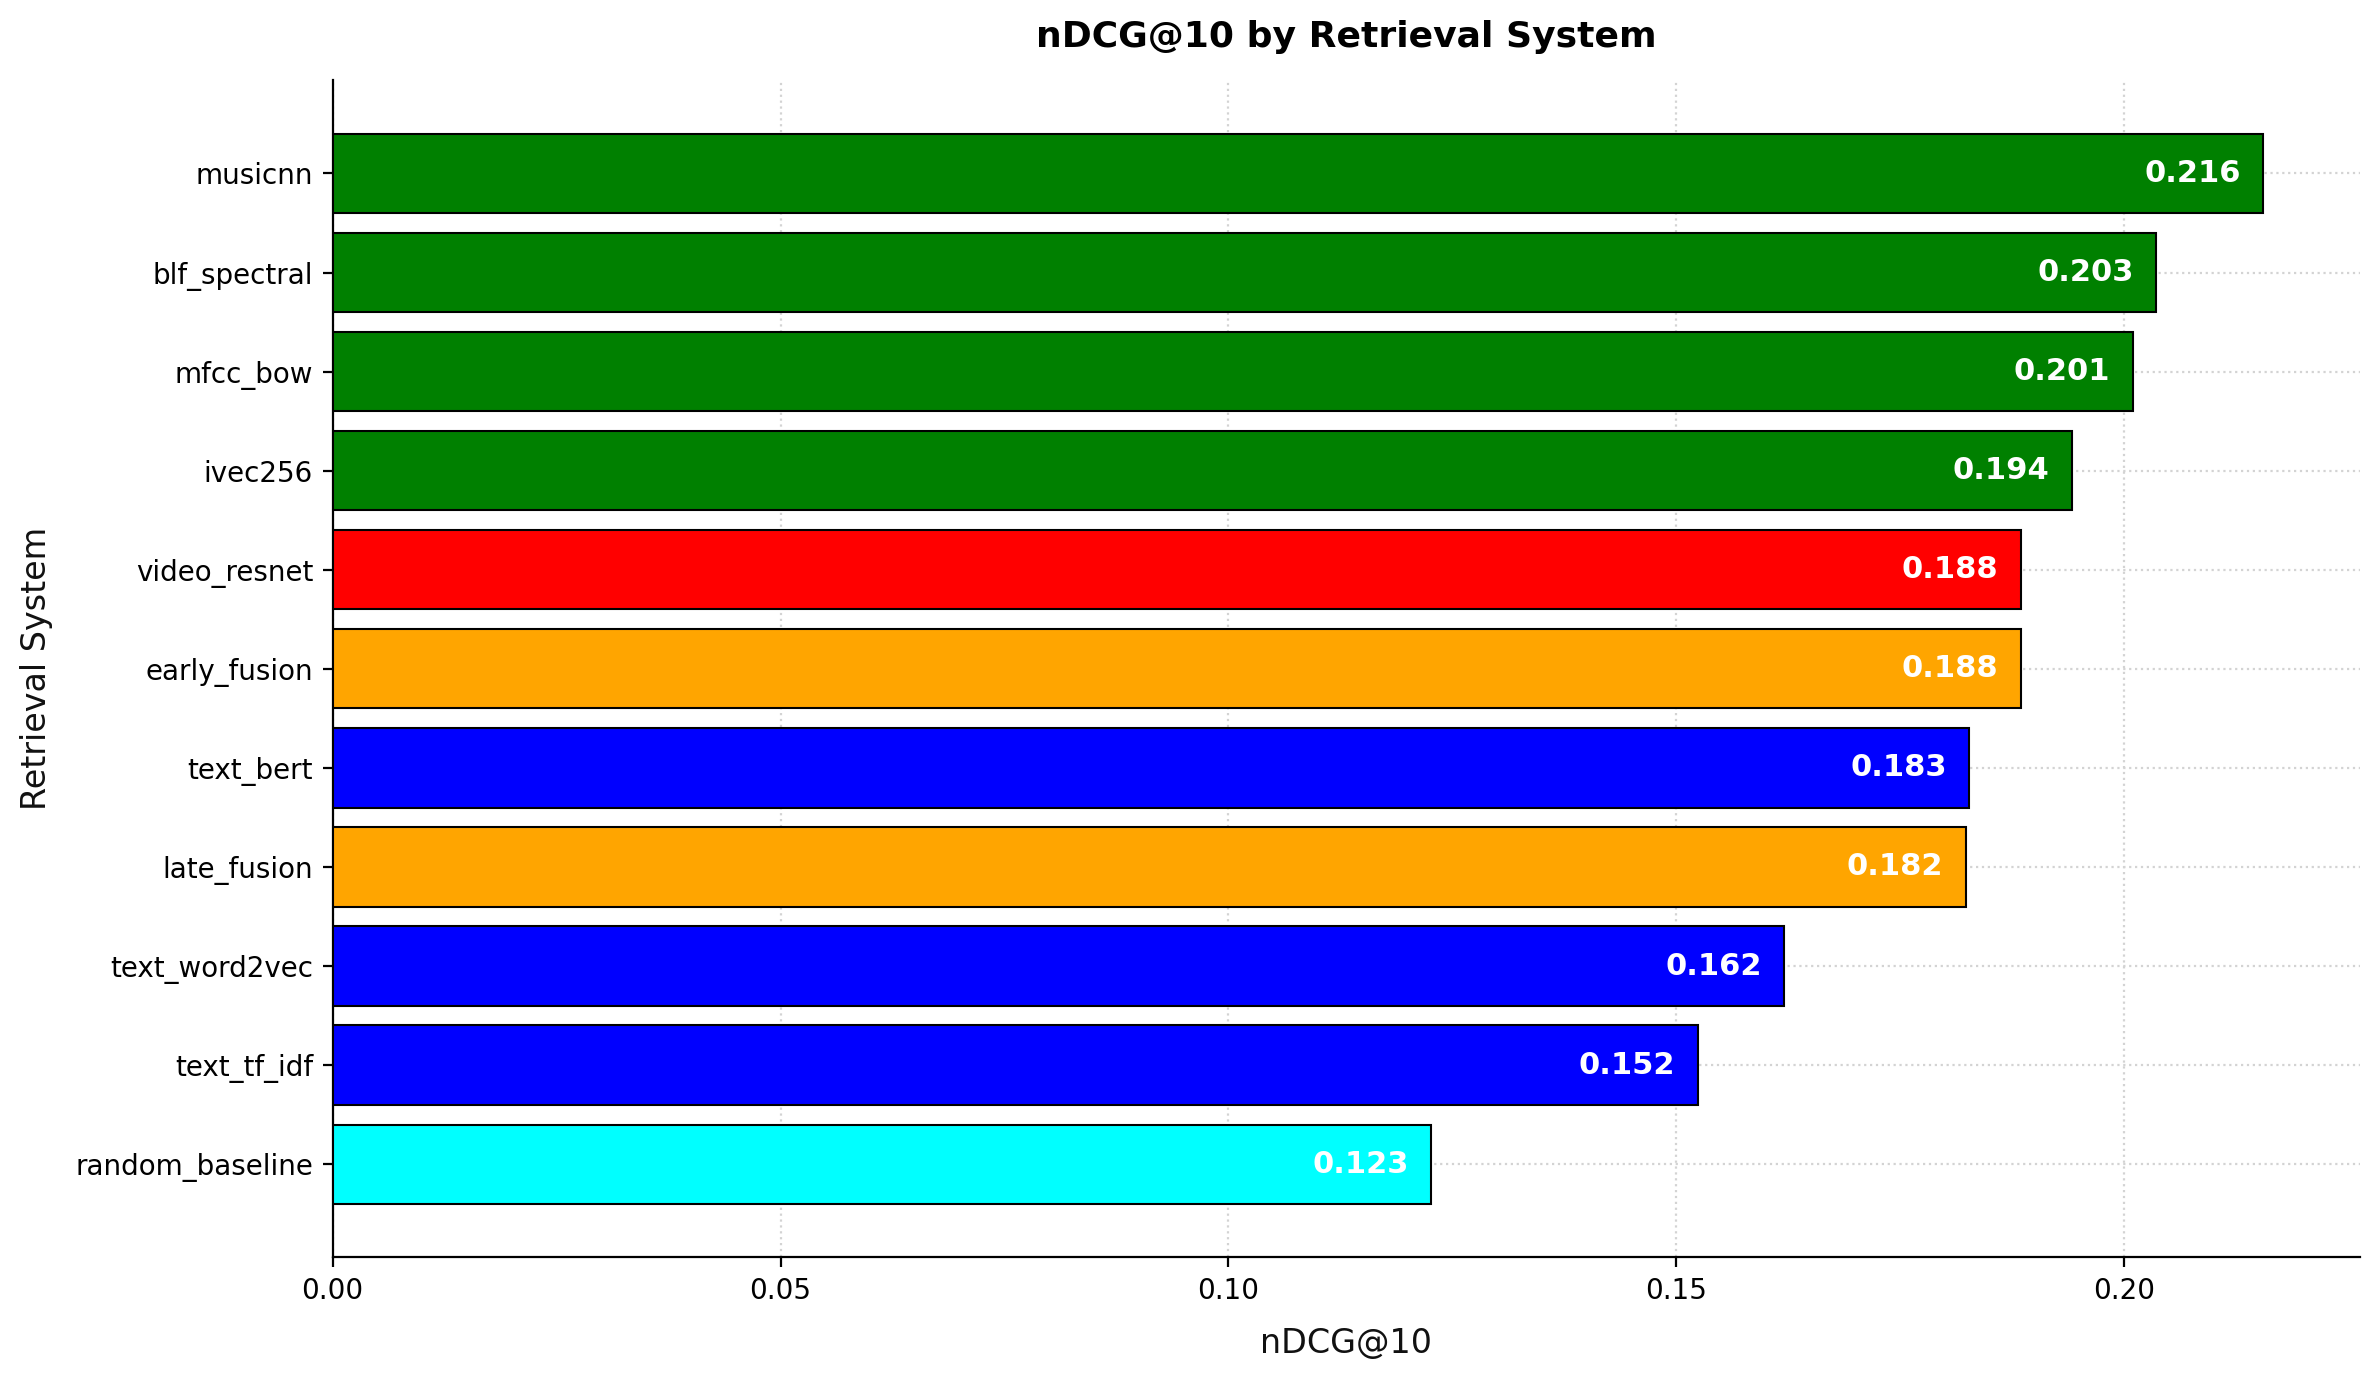

In [9]:
from ndcg import Ndcg

ndcg = Ndcg(genres)
ndcg.compute()
ndcg.plot(our_chosen_retrievals)

## Beyond Accuracy
### 1. Genre Coverage@10

Error syncing cache with disk: Unterminated string starting at: line 1 column 32551791 (char 32551790)
  --> Loading pickled data from pickled_state/genre_coverage_random_baseline.pickle
  --> Loading pickled data from pickled_state/genre_coverage_text_tf_idf.pickle
  --> Loading pickled data from pickled_state/genre_coverage_text_bert.pickle
  --> Loading pickled data from pickled_state/genre_coverage_text_word2vec.pickle
  --> Loading pickled data from pickled_state/genre_coverage_musicnn.pickle
  --> Loading pickled data from pickled_state/genre_coverage_mfcc_bow.pickle
  --> Loading pickled data from pickled_state/genre_coverage_mfcc_stats.pickle
  --> Loading pickled data from pickled_state/genre_coverage_ivec256.pickle
  --> Loading pickled data from pickled_state/genre_coverage_ivec512.pickle
  --> Loading pickled data from pickled_state/genre_coverage_ivec1024.pickle
  --> Loading pickled data from pickled_state/genre_coverage_blf_correlation.pickle
  --> Loading pickled data f

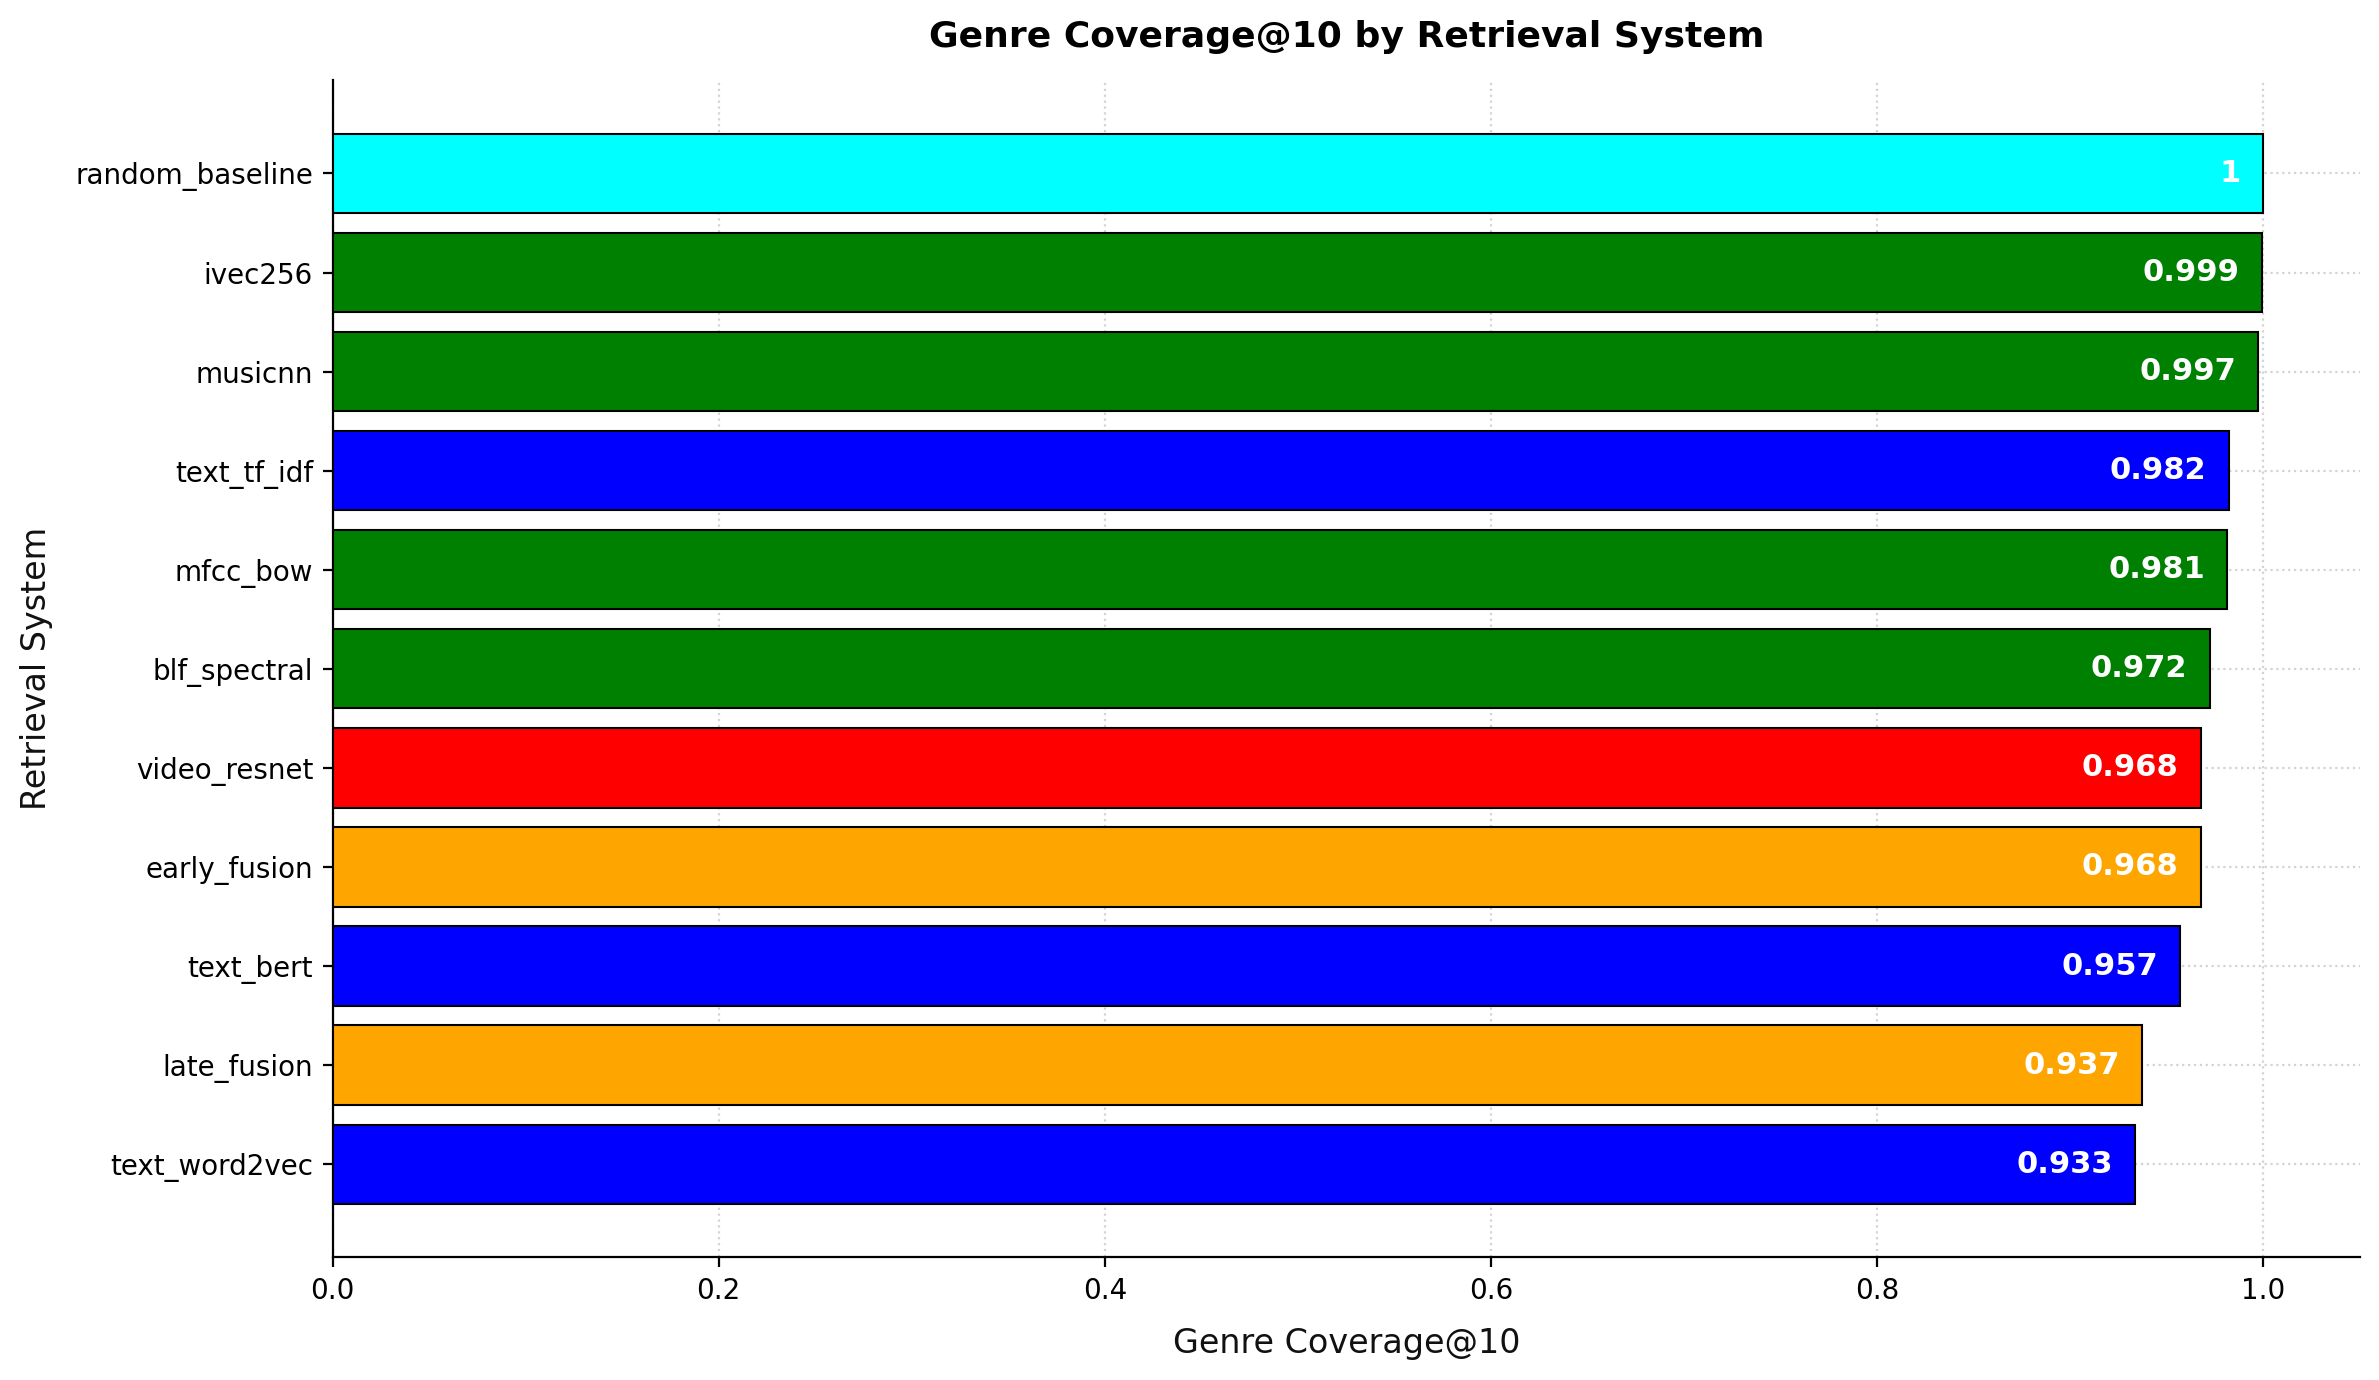

In [10]:
from genre_coverage import GenreCoverage

genres_coverage = GenreCoverage(genres)
genres_coverage.compute()
genres_coverage.plot(our_chosen_retrievals)

### 2. Genre Diversity@10

Error syncing cache with disk: Unterminated string starting at: line 1 column 32551791 (char 32551790)
  --> Loading pickled data from pickled_state/genre_diversity_random_baseline.pickle
  --> Loading pickled data from pickled_state/genre_diversity_text_tf_idf.pickle
  --> Loading pickled data from pickled_state/genre_diversity_text_bert.pickle
  --> Loading pickled data from pickled_state/genre_diversity_text_word2vec.pickle
  --> Loading pickled data from pickled_state/genre_diversity_musicnn.pickle
  --> Loading pickled data from pickled_state/genre_diversity_mfcc_bow.pickle
  --> Loading pickled data from pickled_state/genre_diversity_mfcc_stats.pickle
  --> Loading pickled data from pickled_state/genre_diversity_ivec256.pickle
  --> Loading pickled data from pickled_state/genre_diversity_ivec512.pickle
  --> Loading pickled data from pickled_state/genre_diversity_ivec1024.pickle
  --> Loading pickled data from pickled_state/genre_diversity_blf_correlation.pickle
  --> Loading pic

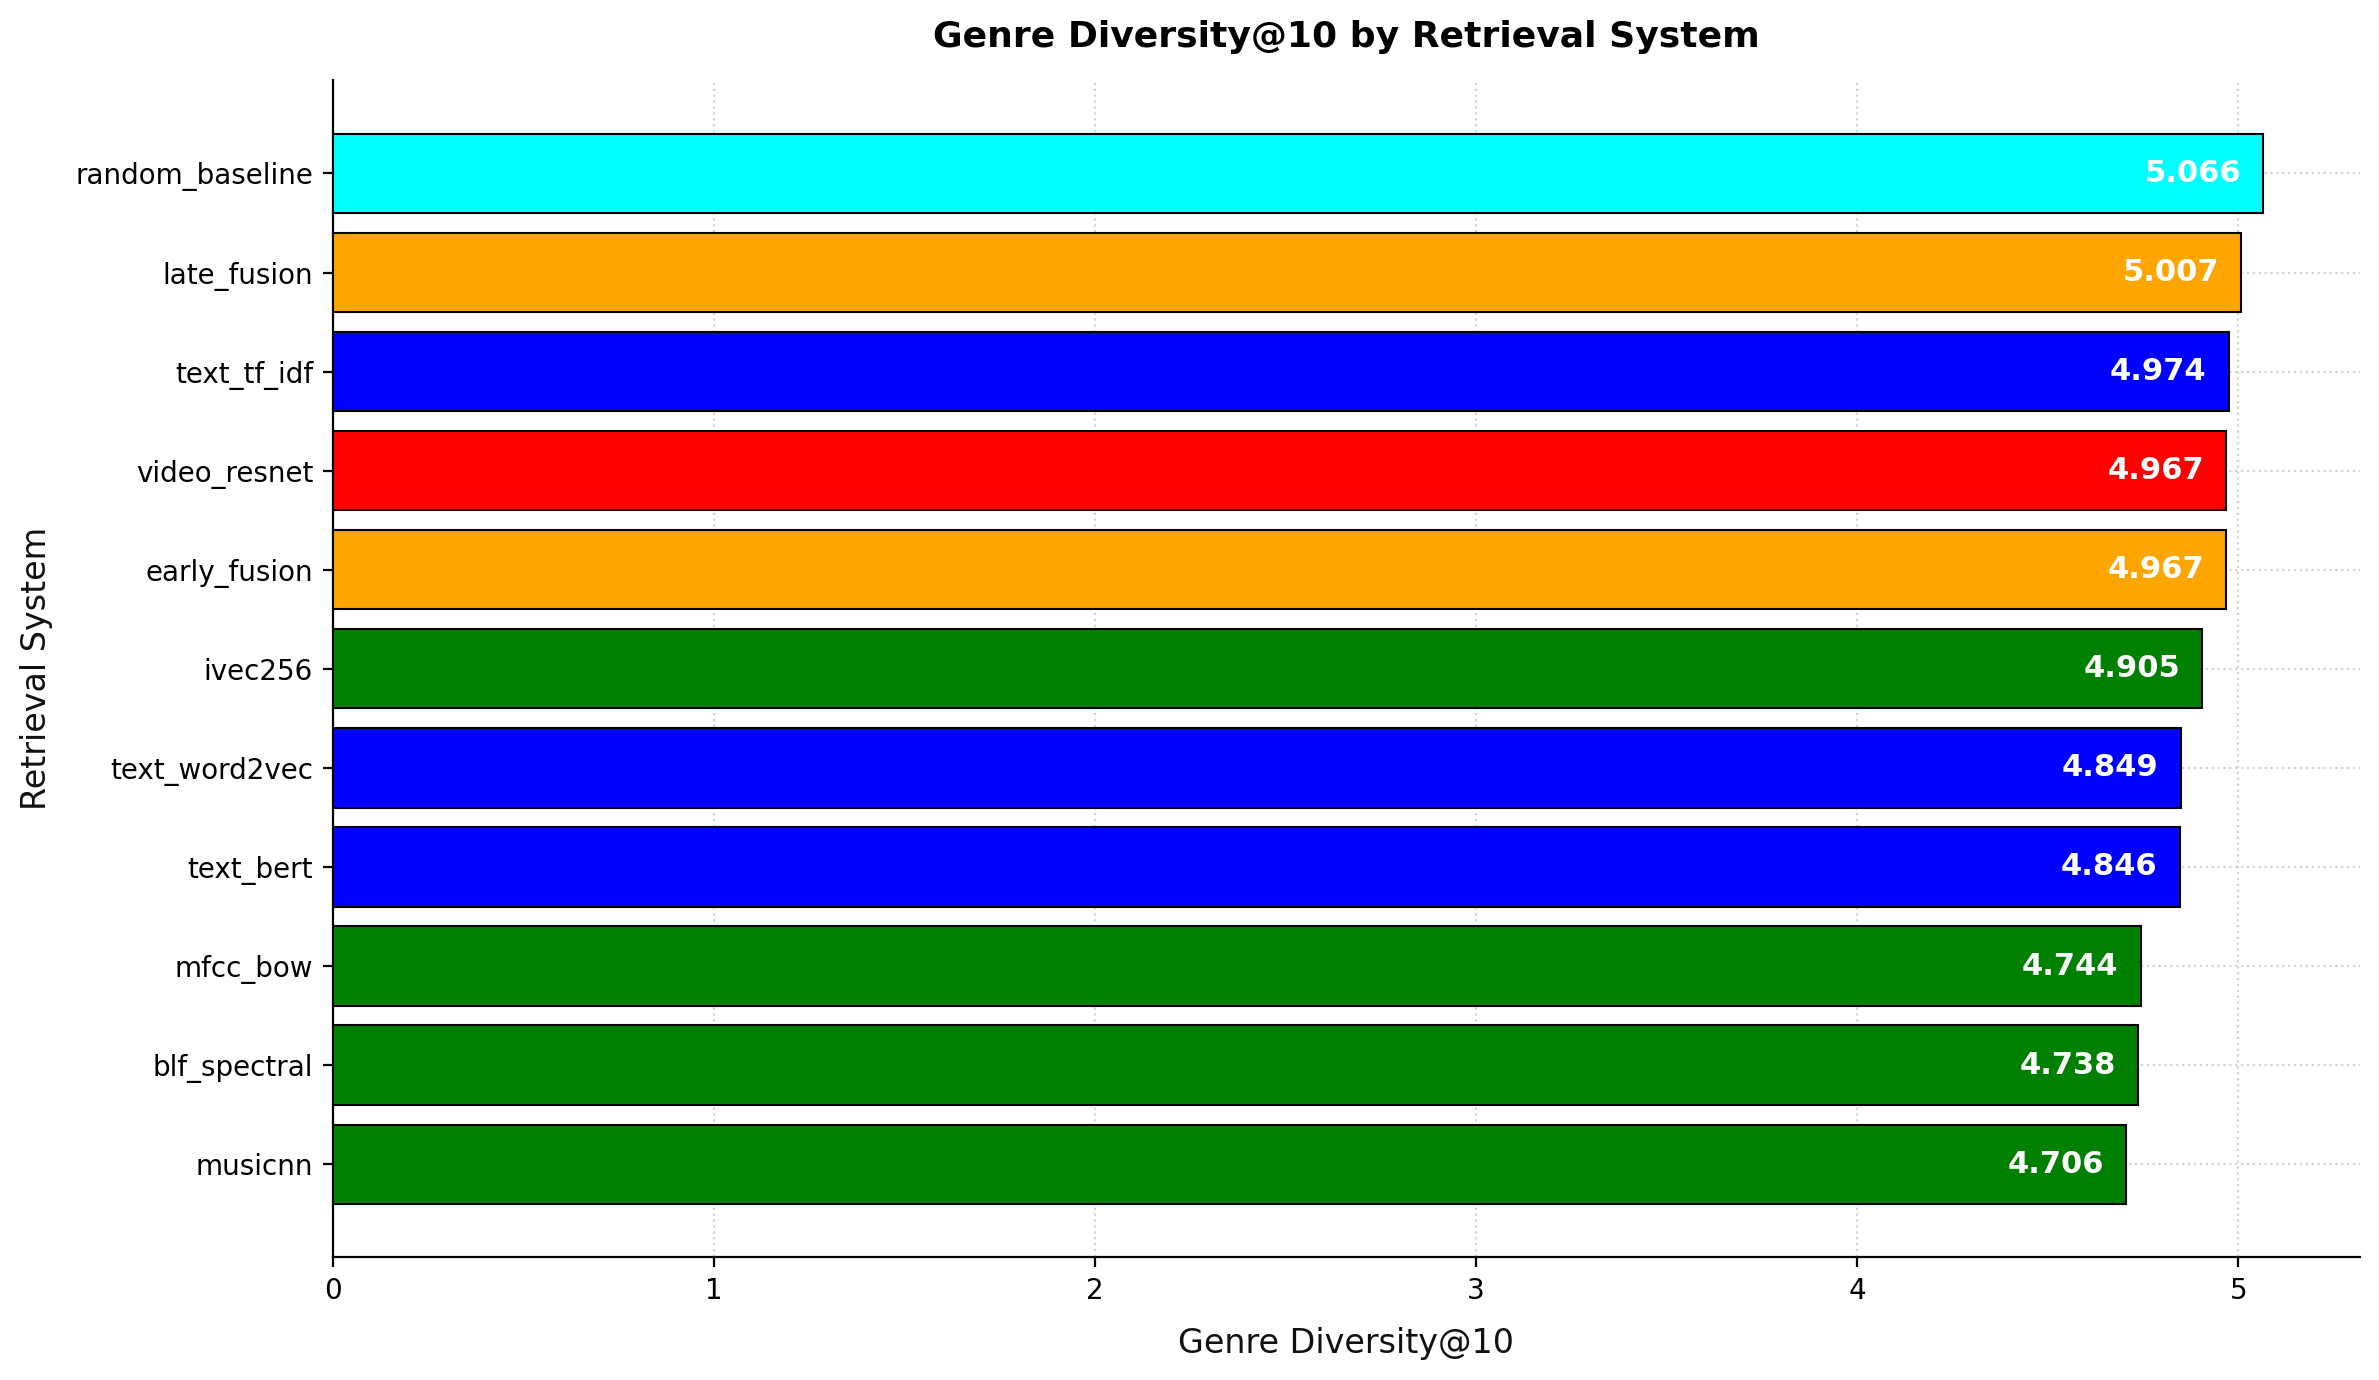

In [2]:
from genre_diversity import GenreDiversity

genres_diversity = GenreDiversity(genres)
genres_diversity.compute()
genres_diversity.plot(our_chosen_retrievals)

## Combined Score

<!-- F_1 score: harmonic mean of precision and recall

We want to achieve a balance between finding similar tracks, but also 

eg that we want diversity high and genre coverage low -->

justification for choosing which values we want to get high or low:
we want to achieve the "opposite" of random baseline - eg 

- precision: random baseline scores low -> we want high precision
- genre diversity: random baseline scores high -> we want low genre diversity

why? we view random baseline as the worst "system", because there is no systematic approach behind it

we want to find a balance between classical and user-centric metrics: we use 2 classical (f1 score + ndcg) and 2 user-centric (genre coverage + genre diversity) metrics; this is why we weight each metric equally (25%)

the report should be divided in 4 category sections + 1 summary section: text, audio, video, fusion; each section starts with a chart composed of combined scores of all available retrieval systems in that category - we give our justification for choosing the systems for the final comparison based on the chart; the summary section contains all other charts with just our chosen features



Error syncing cache with disk: Unterminated string starting at: line 1 column 32551791 (char 32551790)
Calculating precision and recall for random_baseline
  --> Loading pickled data from pickled_state/precision_recall_random_baseline.pickle
Calculating precision and recall for text_tf_idf
  --> Loading pickled data from pickled_state/precision_recall_text_tf_idf.pickle
Calculating precision and recall for text_bert
  --> Loading pickled data from pickled_state/precision_recall_text_bert.pickle
Calculating precision and recall for text_word2vec
  --> Loading pickled data from pickled_state/precision_recall_text_word2vec.pickle
Calculating precision and recall for musicnn
  --> Loading pickled data from pickled_state/precision_recall_musicnn.pickle
Calculating precision and recall for mfcc_bow
  --> Loading pickled data from pickled_state/precision_recall_mfcc_bow.pickle
Calculating precision and recall for mfcc_stats
  --> Loading pickled data from pickled_state/precision_recall_mfcc_s

Computing nDCG in chunks of 1000:   0%|          | 0/11 [00:00<?, ?it/s]

  --> Loading pickled data from pickled_state/ndcg_10_chunk_0.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_1.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_2.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_3.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_4.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_5.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_6.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_7.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_8.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_9.pickle
  --> Loading pickled data from pickled_state/ndcg_10_chunk_10.pickle
  --> Loading pickled data from pickled_state/genre_coverage_random_baseline.pickle
  --> Loading pickled data from pickled_state/genre_coverage_text_tf_idf.pickle
  --> Loading pickled data from pickled_state/genre_coverage_text_bert.pickl

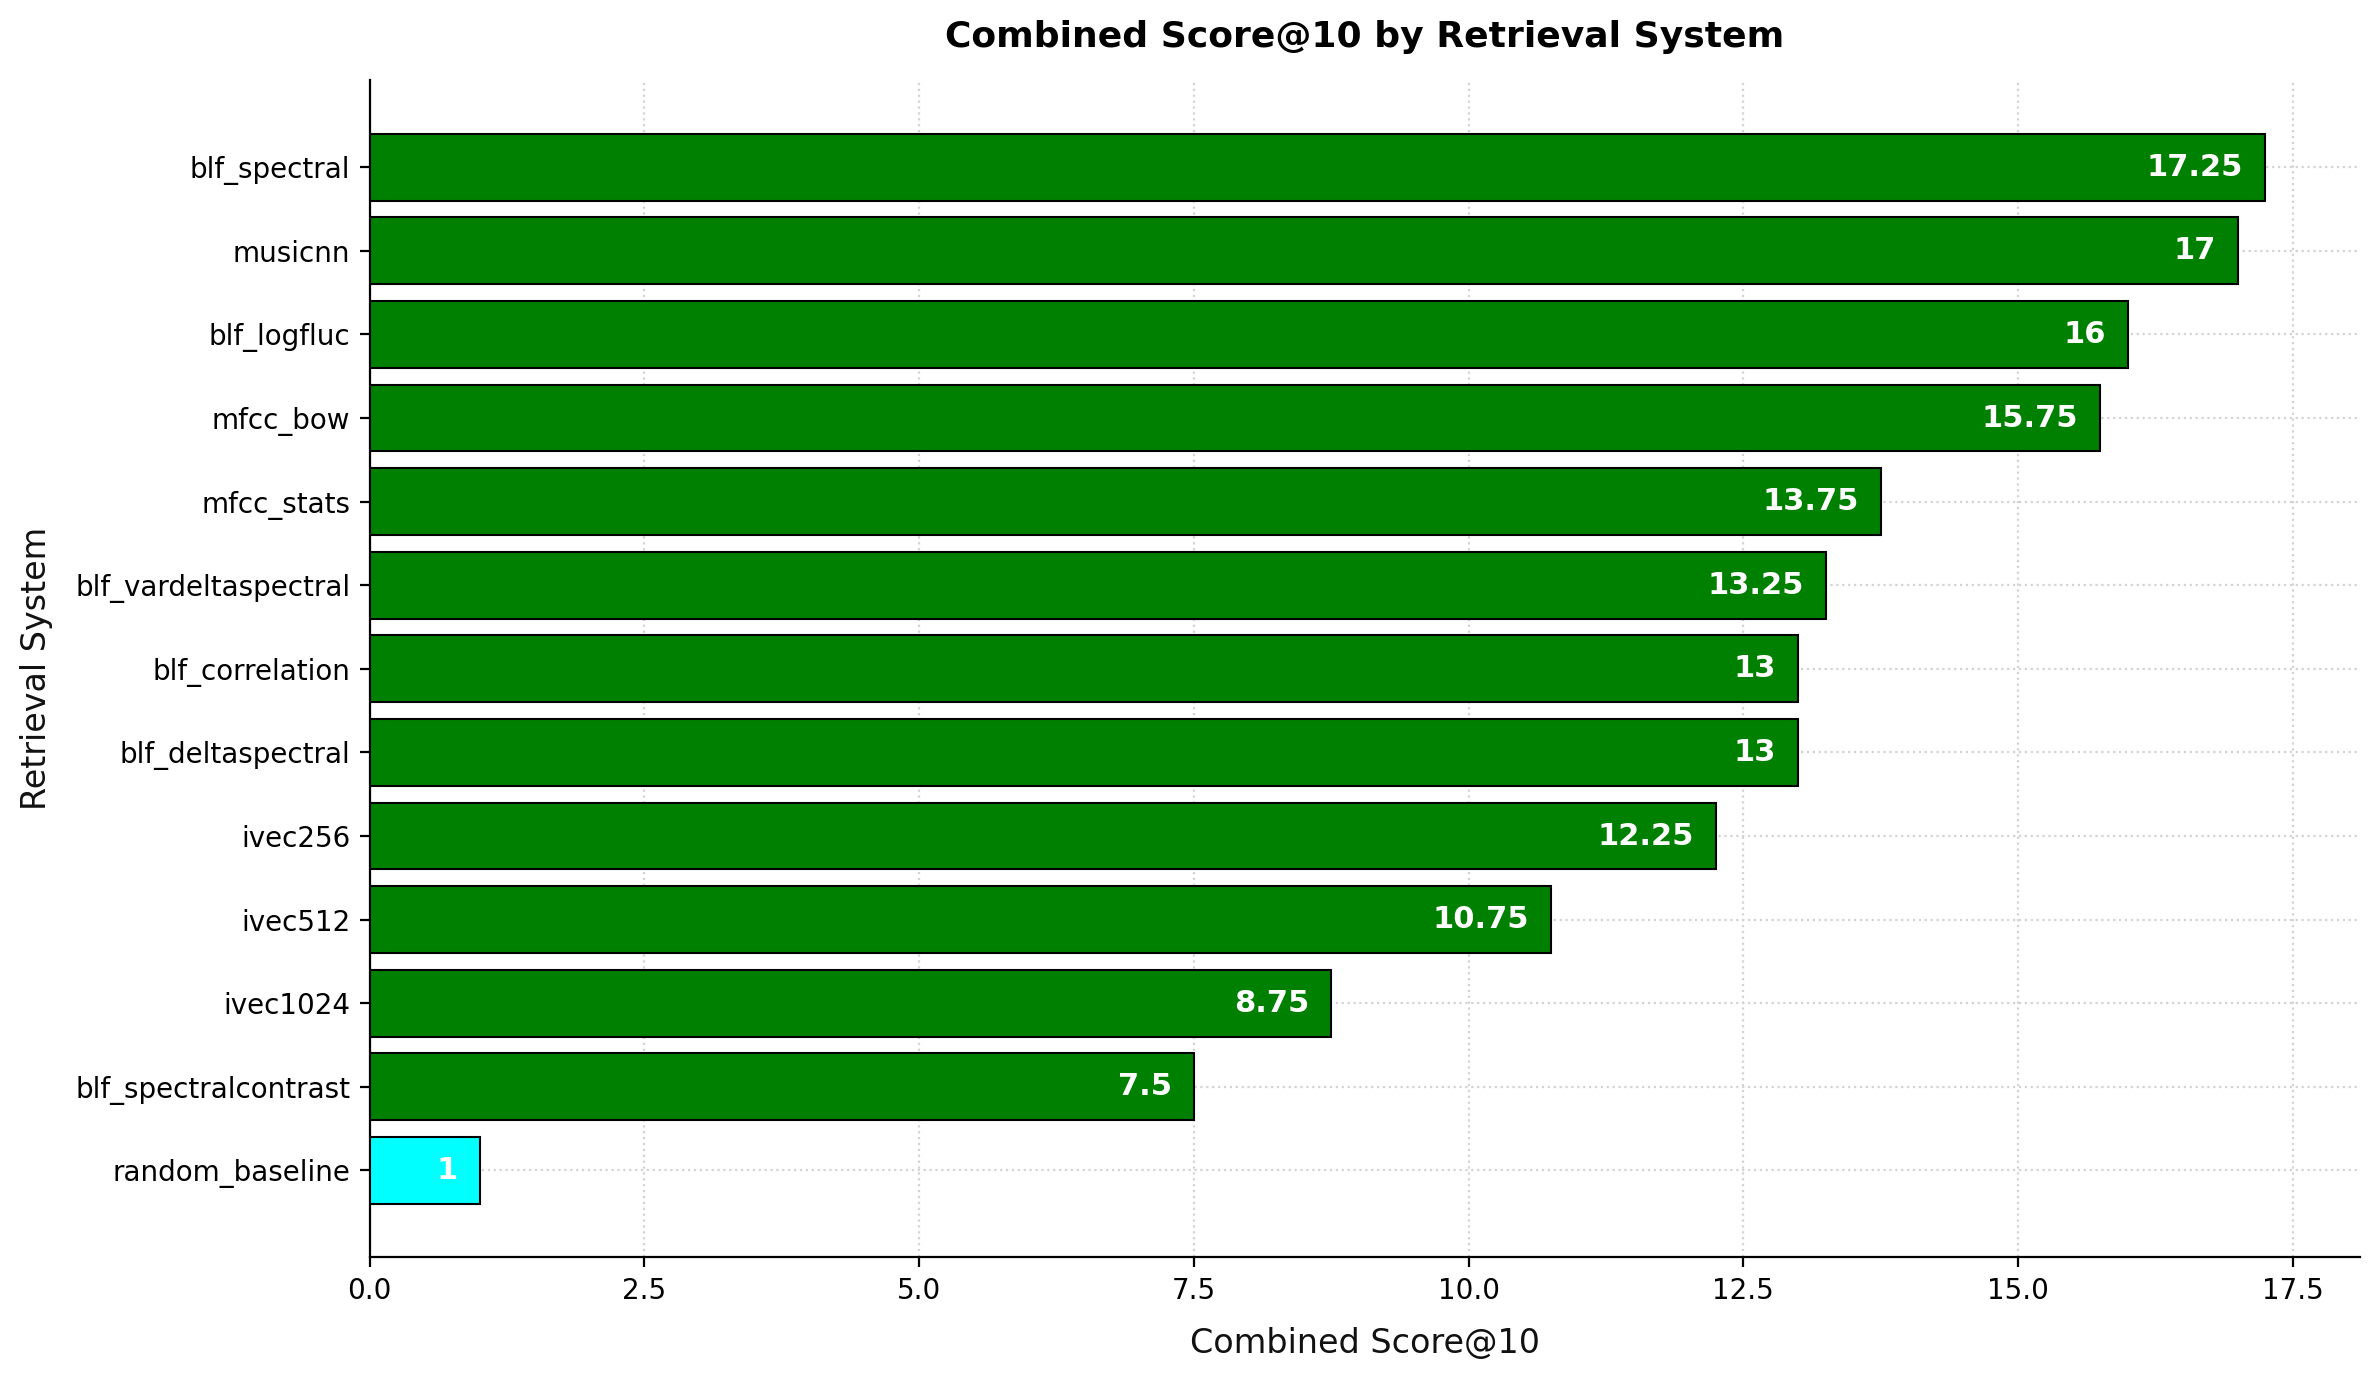

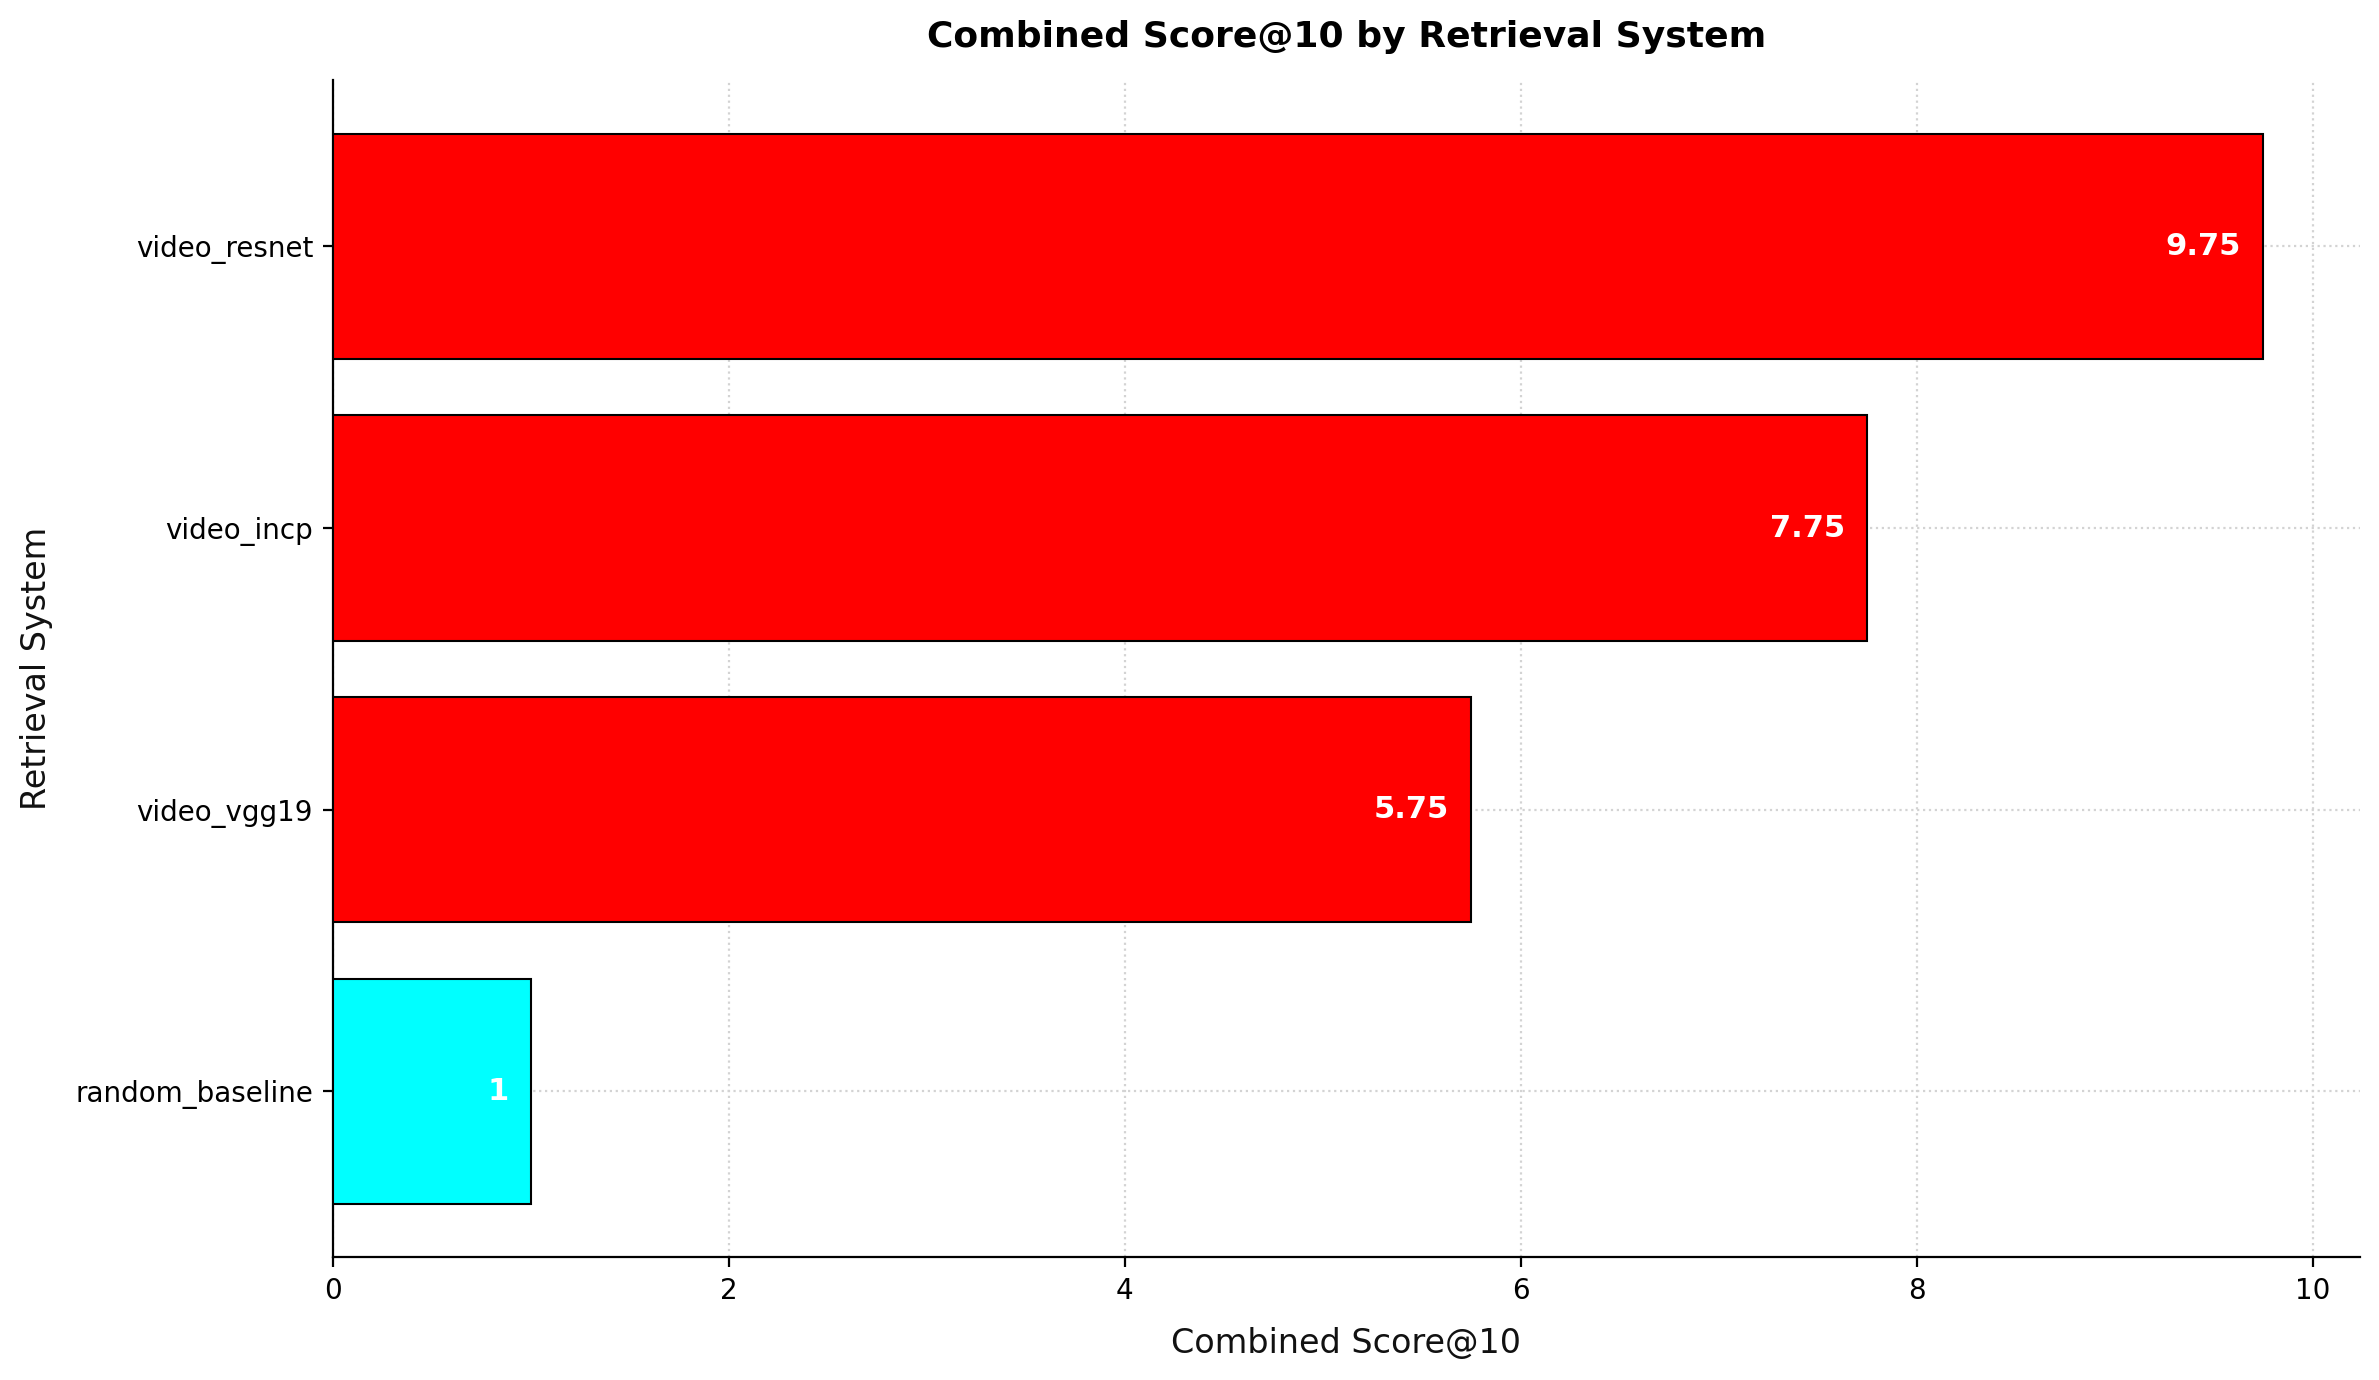

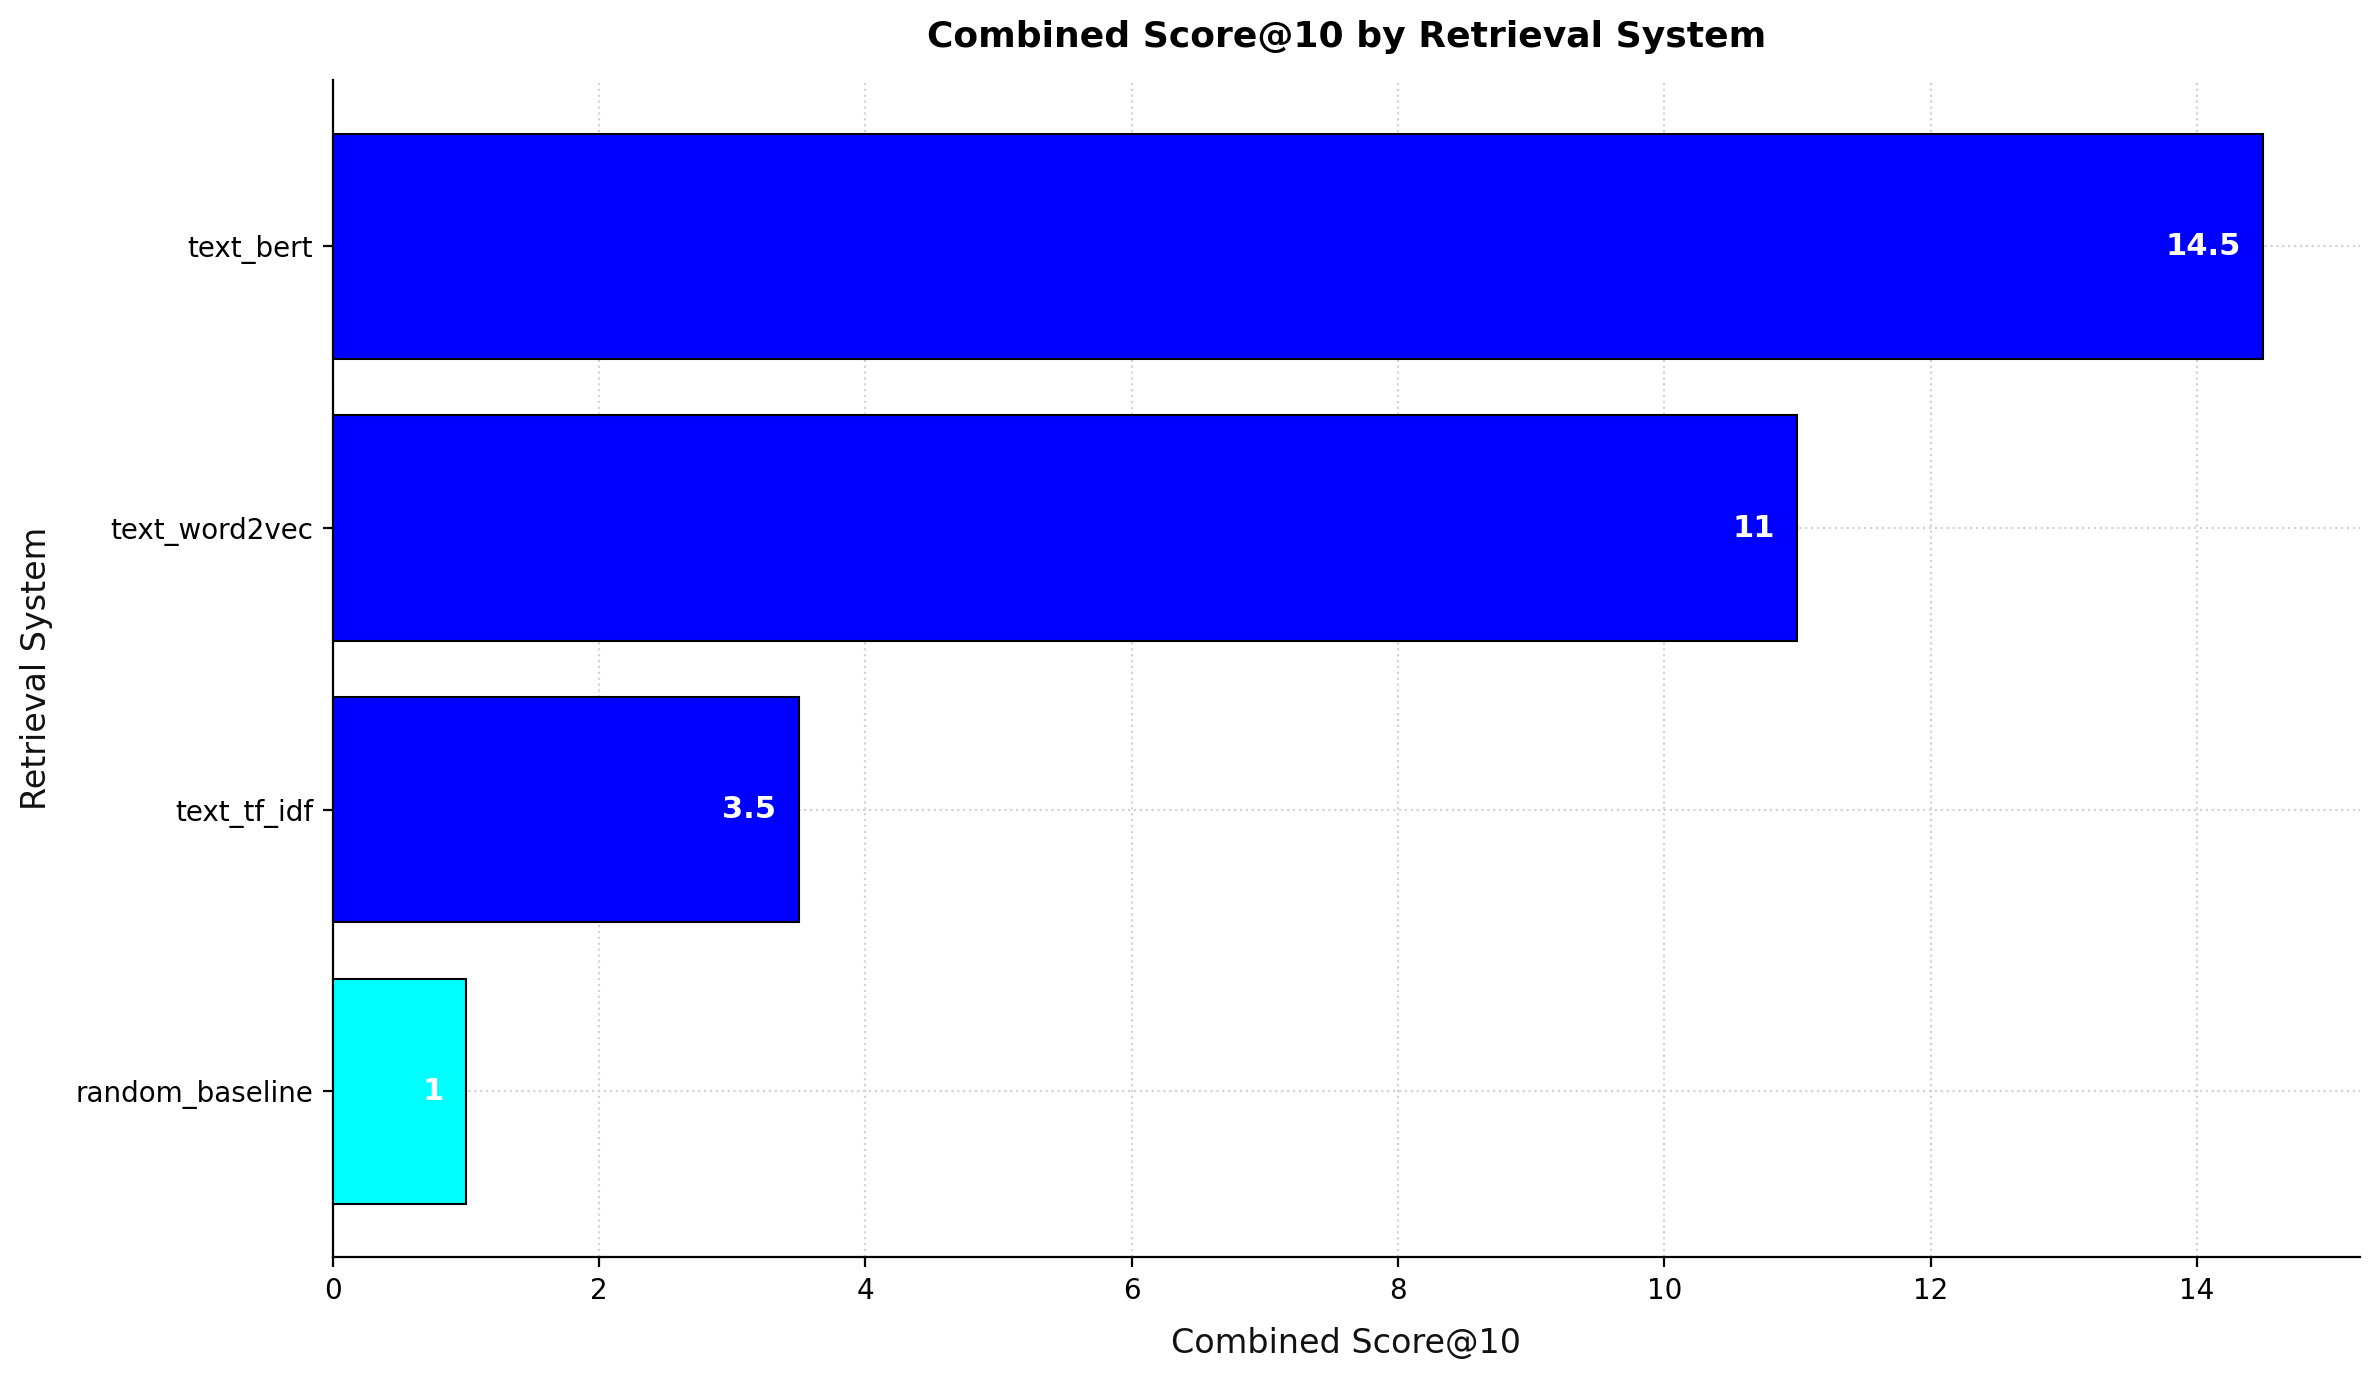

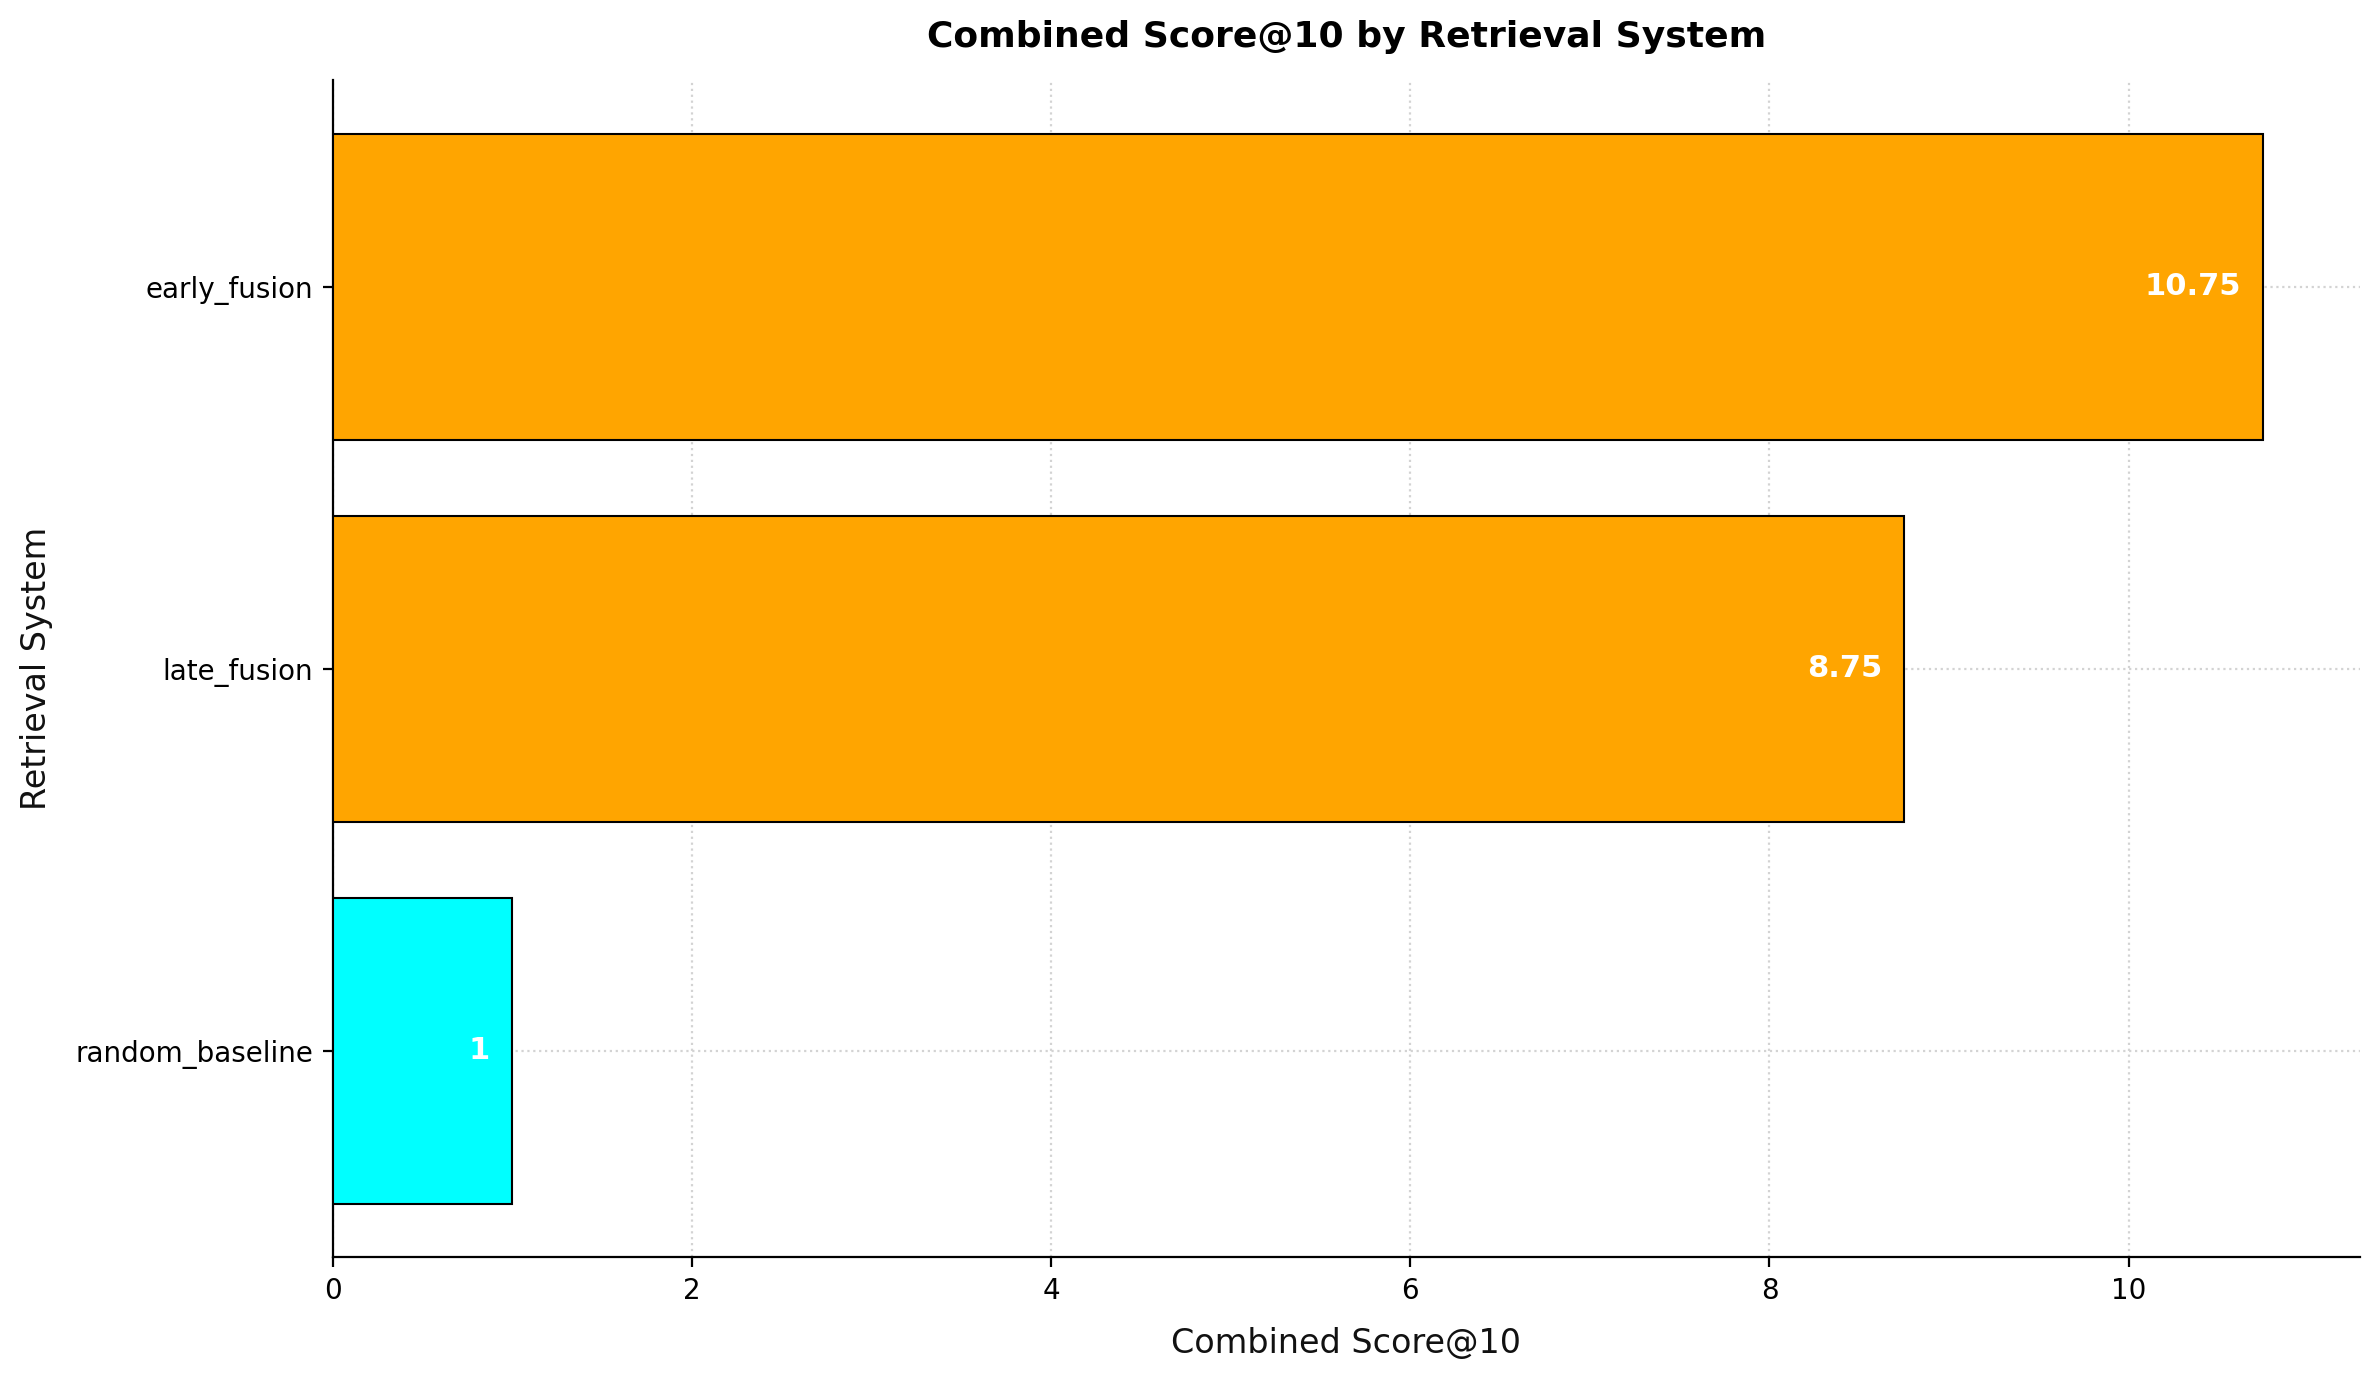

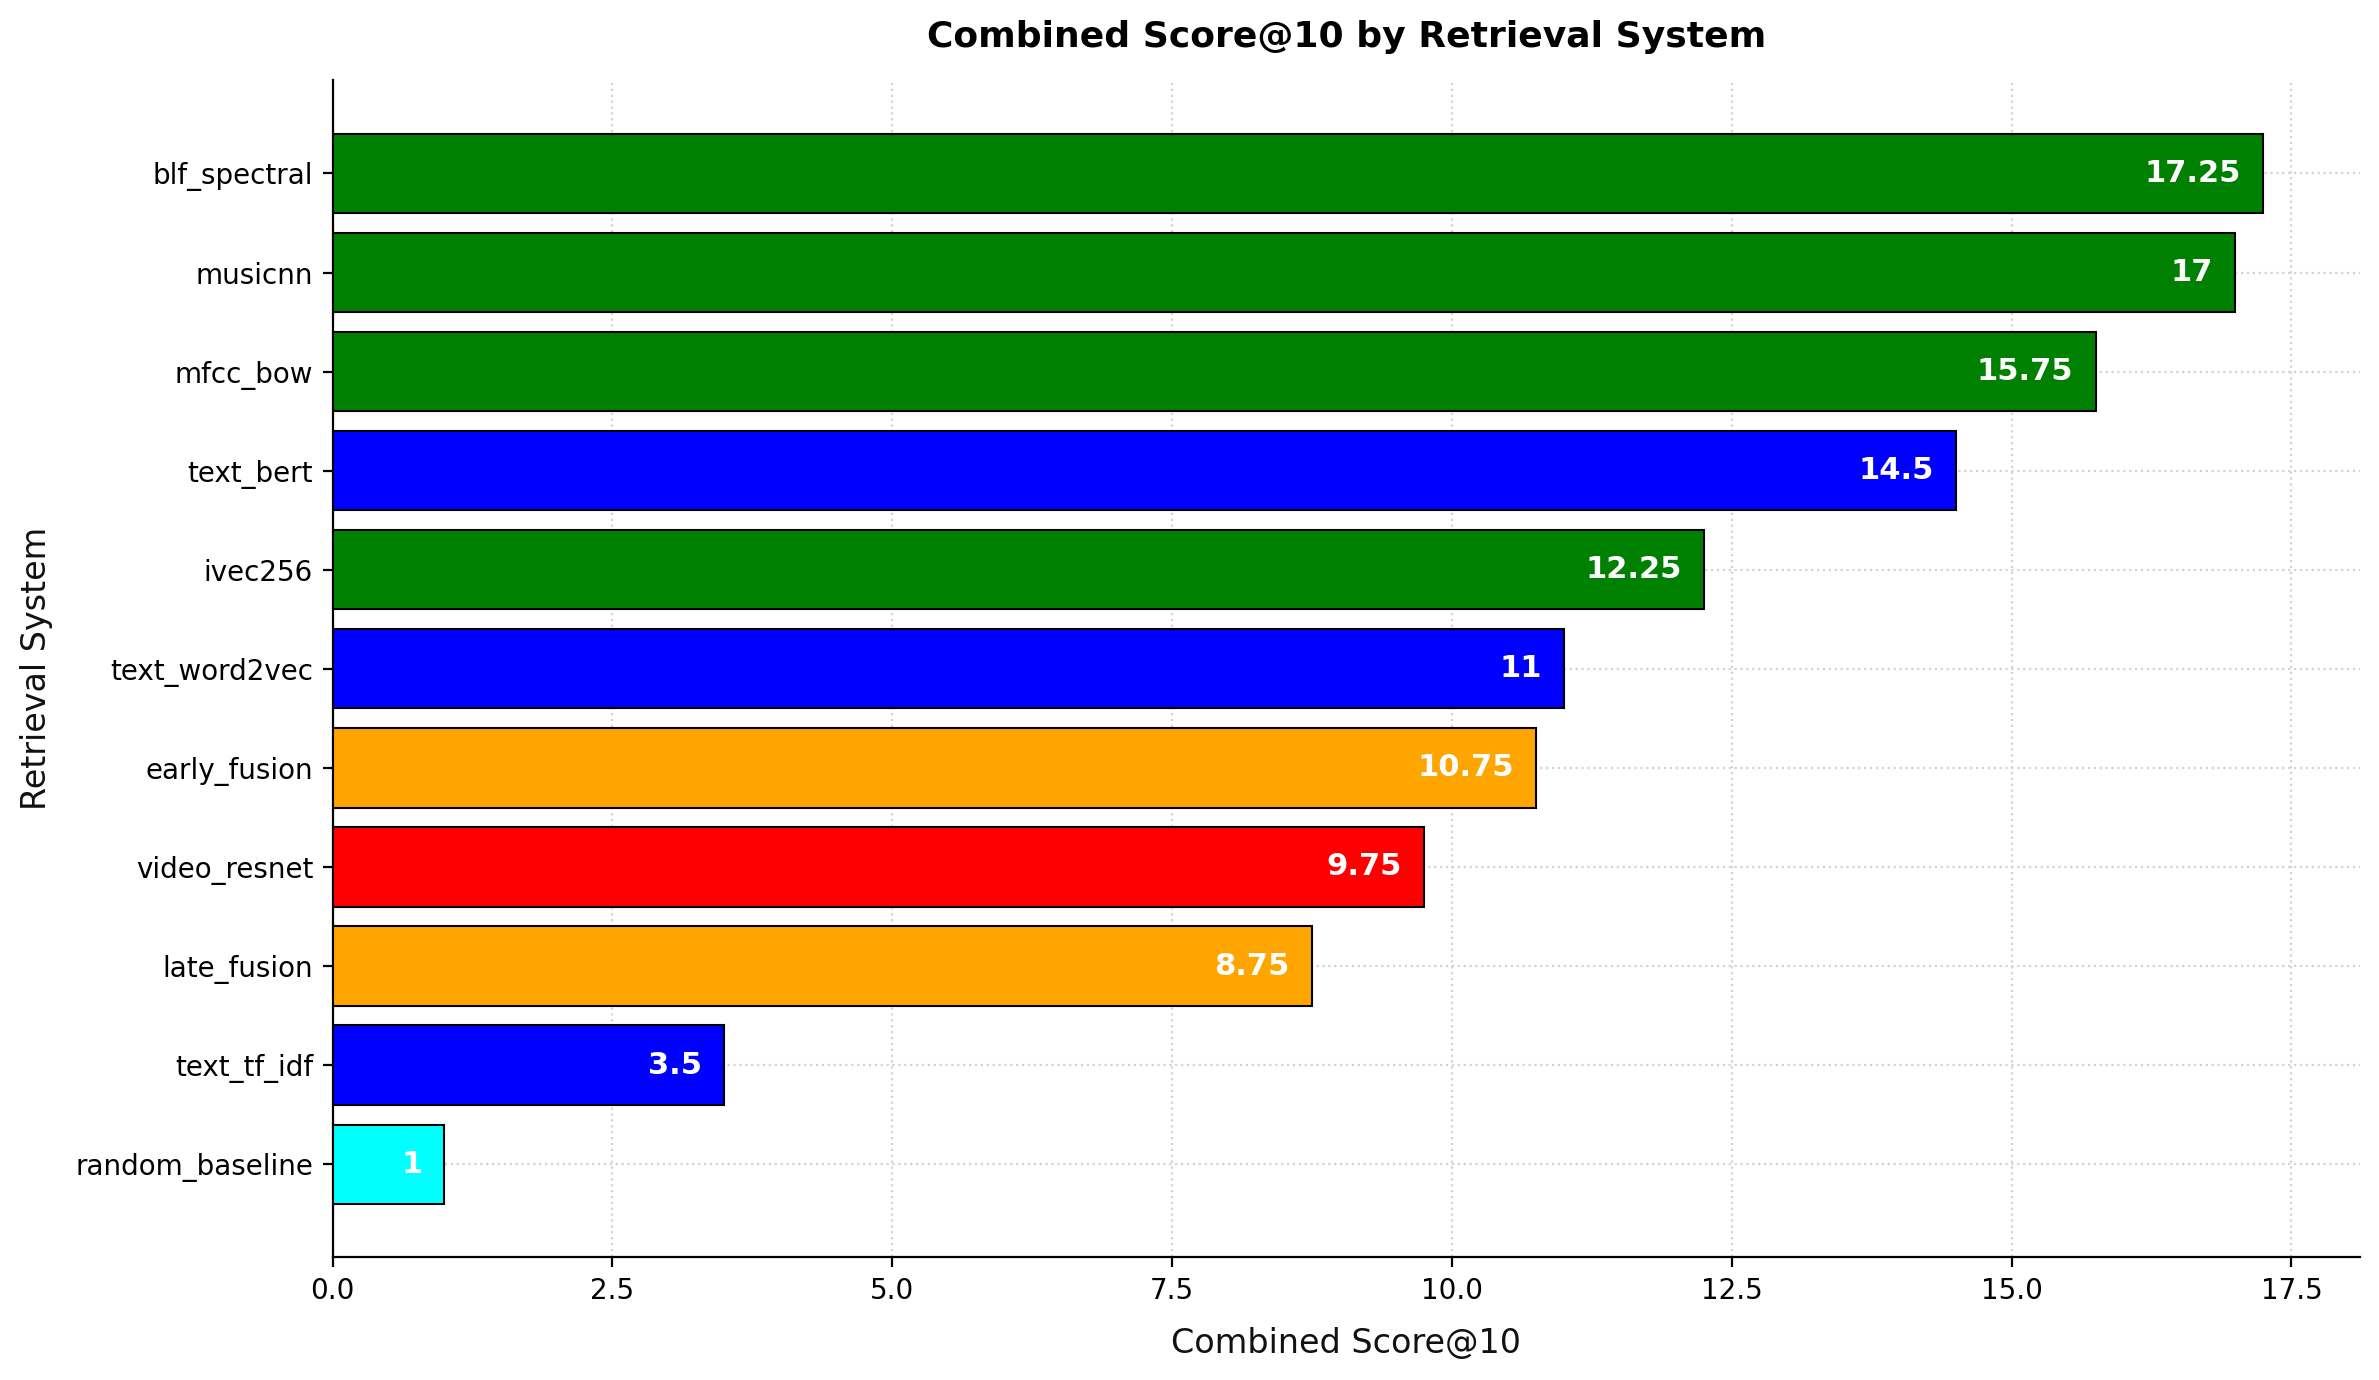

In [3]:
from combined_score import CombinedScore

combined_score = CombinedScore(genres)
combined_score.compute()

combined_score.plot(get_retrieval_names_for_types(["random", "audio"]))
combined_score.plot(get_retrieval_names_for_types(["random", "video"]))
combined_score.plot(get_retrieval_names_for_types(["random", "text"]))
combined_score.plot(get_retrieval_names_for_types(["random", "fusion"]))
combined_score.plot(our_chosen_retrievals)

# Frontend

In [ ]:
# precompute retrievals (for frontend and chached lookup)

# only do this if you want to recompute the retrieval

#retrieval = Retrieval(n=100)
#retrieval.precompute_all(threads=4)

In [ ]:
from utils import write_song_df_to_json_file

write_song_df_to_json_file("frontend/static/songMeta.json", datasets.information.df, datasets.url.df, datasets.genres.df)

# frontend uses frontend/static/songMeta.json and retrievals/*.json
